In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

### fix the seed
np.random.seed(0)

### simulate the data
X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
bins = 15

### fit naive bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)
clf_proba = clf.predict_proba(X_cv)[:, 1]

### fit isotonic regression
isotonic_regression = IsotonicRegression(y_min=0, y_max=1, increasing=True)
isotonic_regression.fit(clf_proba, y_cv)

### predict probabilities
uncalibrated_prob = clf.predict_proba(X_test)[:, 1]
calibrated_prob = isotonic_regression.predict(uncalibrated_prob)

### compute score
logloss = log_loss(y_test, uncalibrated_prob)
roc = roc_auc_score(y_test, uncalibrated_prob)
calibrated_loss = log_loss(y_test, calibrated_prob)
calibrated_roc = roc_auc_score(y_test, calibrated_prob)

### plot calibration curve
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, uncalibrated_prob, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, label=f'Naive Bayes: logloss({logloss:1.3f}) auc({roc:1.3f})')
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, calibrated_prob, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives,
         label=f'Calibrated Naive Bayes: logloss({calibrated_loss:1.3f}) auc({calibrated_roc:1.3f})')
plt.ylabel('Empirical probability')
plt.xlabel('Predicted Probability')
plt.legend(loc='lower right')
plt.show()


<Figure size 640x480 with 1 Axes>

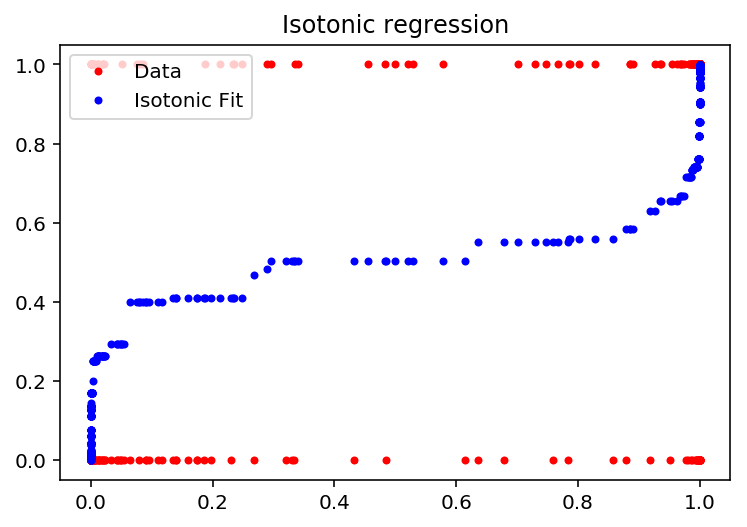

In [22]:
fig = plt.figure()
plt.plot(clf_proba[:500], y_cv[:500], 'r.', markersize=6)
plt.plot(clf_proba[:500], isotonic_regression.predict(clf_proba)[:500], 'b.', markersize=6)
plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='upper left')
plt.title('Isotonic regression')
plt.show()

In [2]:
### add callback in isotonic_regression
def isotonic_regression(y, weight=None, y_min=None, y_max=None, callback=None):
    """Solve the isotonic regression model::

        min sum w[i] (y[i] - y_[i]) ** 2

        subject to y_min = y_[1] <= y_[2] ... <= y_[n] = y_max

    where:
        - y[i] are inputs (real numbers)
        - y_[i] are fitted
        - w[i] are optional strictly positive weights (default to 1.0)

    Parameters
    ----------
    y : iterable of floating-point values
        The data.

    weight : iterable of floating-point values, optional, default: None
        Weights on each point of the regression.
        If None, weight is set to 1 (equal weights).

    y_min : optional, default: None
        If not None, set the lowest value of the fit to y_min.

    y_max : optional, default: None
        If not None, set the highest value of the fit to y_max.

    Returns
    -------
    `y_` : list of floating-point values
        Isotonic fit of y.

    References
    ----------
    "Active set algorithms for isotonic regression; A unifying framework"
    by Michael J. Best and Nilotpal Chakravarti, section 3.
    """
    if weight is None:
        weight = np.ones(len(y), dtype=y.dtype)
    if y_min is not None or y_max is not None:
        y = np.copy(y)
        weight = np.copy(weight)
        C = np.dot(weight, y * y) * 10  # upper bound on the cost function
        if y_min is not None:
            y[0] = y_min
            weight[0] = C
        if y_max is not None:
            y[-1] = y_max
            weight[-1] = C

    active_set = [(weight[i] * y[i], weight[i], [i, ])
                  for i in range(len(y))]
    current = 0
    counter = 0
    while current < len(active_set) - 1:
        value0, value1, value2 = 0, 0, np.inf
        weight0, weight1, weight2 = 1, 1, 1
        while value0 * weight1 <= value1 * weight0 and \
                        current < len(active_set) - 1:
            value0, weight0, idx0 = active_set[current]
            value1, weight1, idx1 = active_set[current + 1]
            if value0 * weight1 <= value1 * weight0:
                current += 1

            if callback is not None:
                callback(y, active_set, counter, idx1)
                counter += 1

        if current == len(active_set) - 1:
            break

        # merge two groups
        value0, weight0, idx0 = active_set.pop(current)
        value1, weight1, idx1 = active_set.pop(current)
        active_set.insert(current,
                          (value0 + value1,
                           weight0 + weight1, idx0 + idx1))
        while value2 * weight0 > value0 * weight2 and current > 0:
            value0, weight0, idx0 = active_set[current]
            value2, weight2, idx2 = active_set[current - 1]
            if weight0 * value2 >= weight2 * value0:
                active_set.pop(current)
                active_set[current - 1] = (value0 + value2, weight0 + weight2,
                                           idx0 + idx2)
                current -= 1

    solution = np.empty(len(y))
    if callback is not None:
        callback(y, active_set, counter+1, idx1)
        callback(y, active_set, counter+2, idx1)
    for value, weight, idx in active_set:
        solution[idx] = value / weight
    return solution

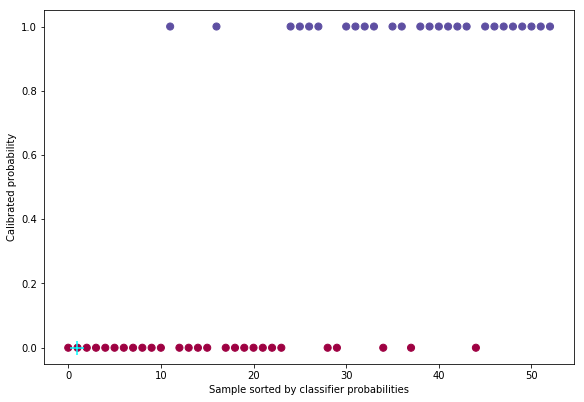

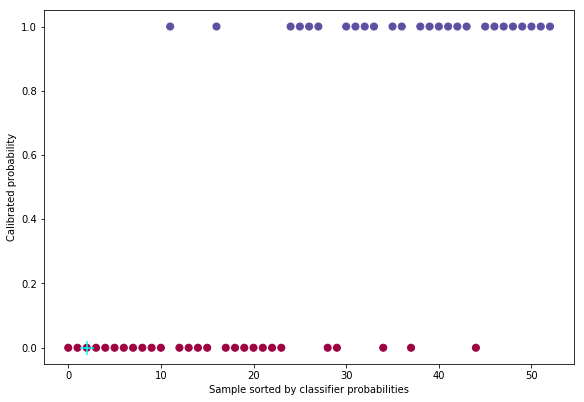

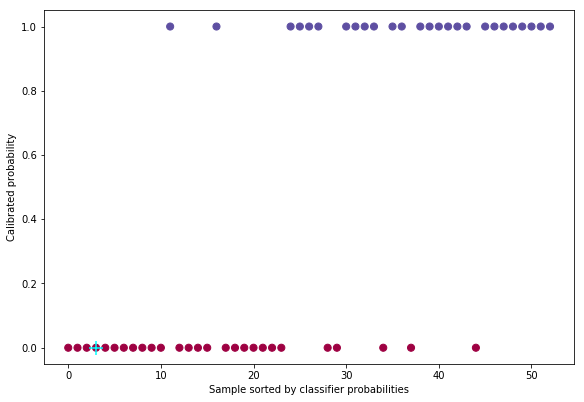

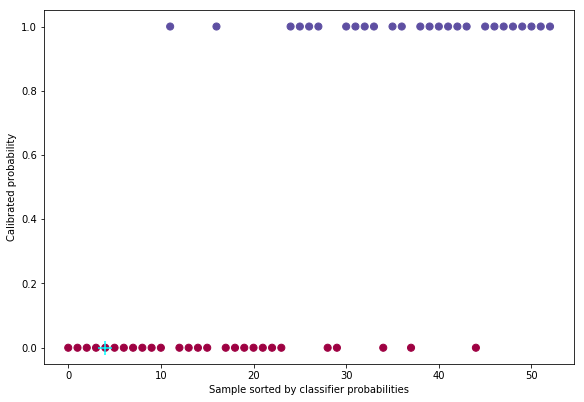

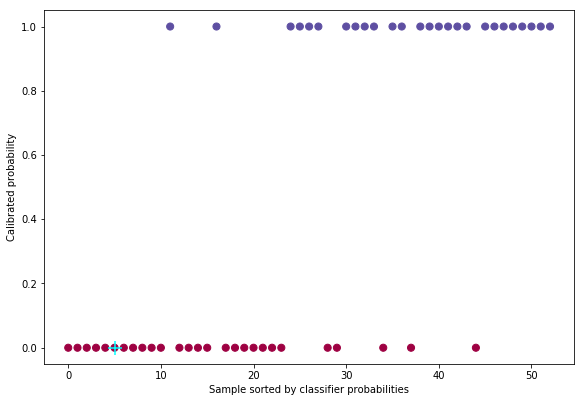

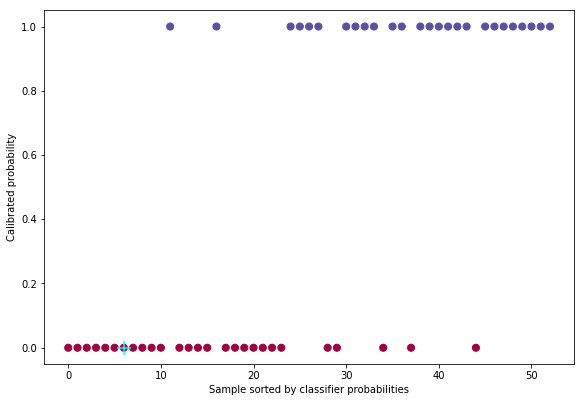

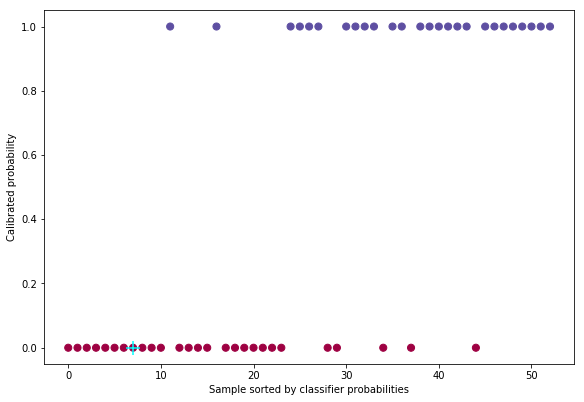

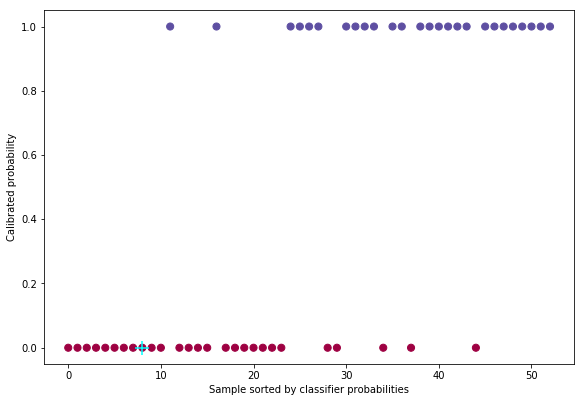

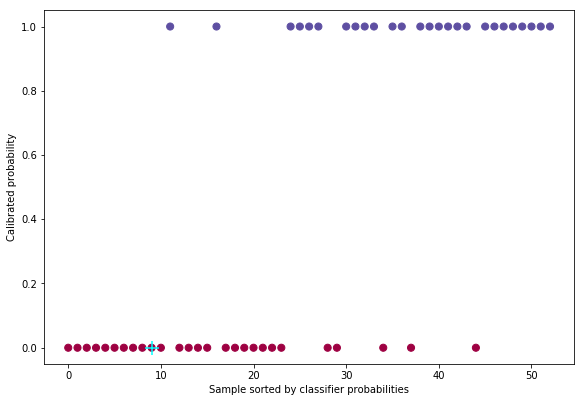

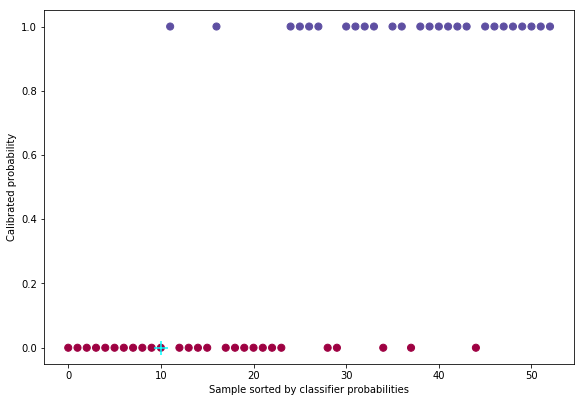

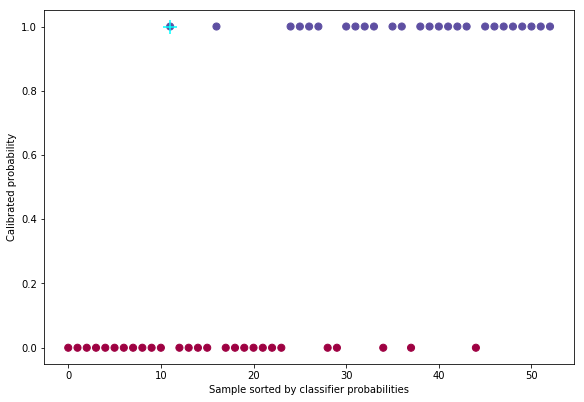

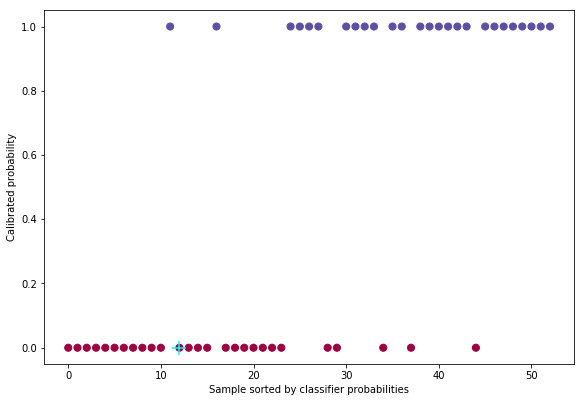

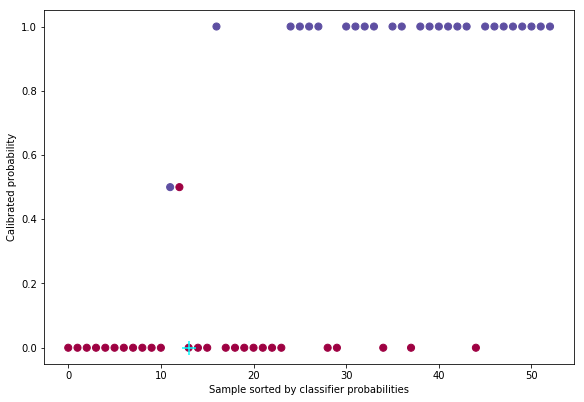

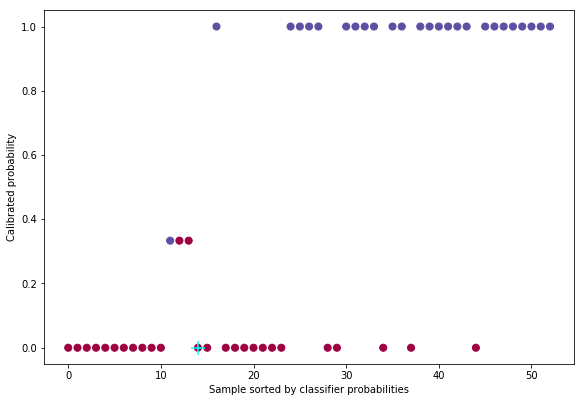

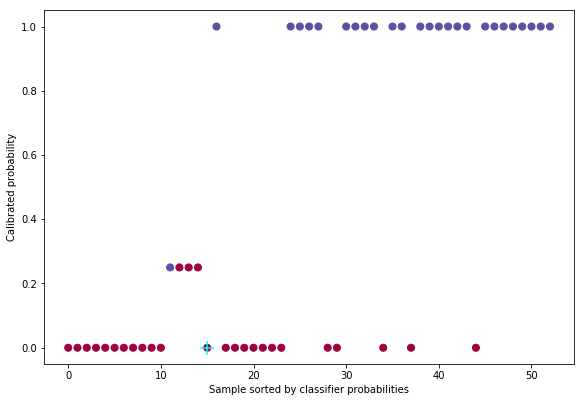

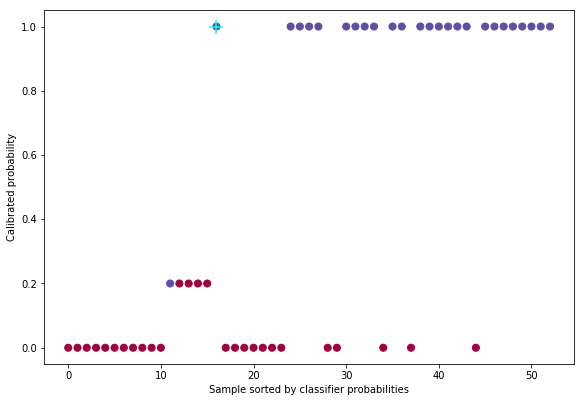

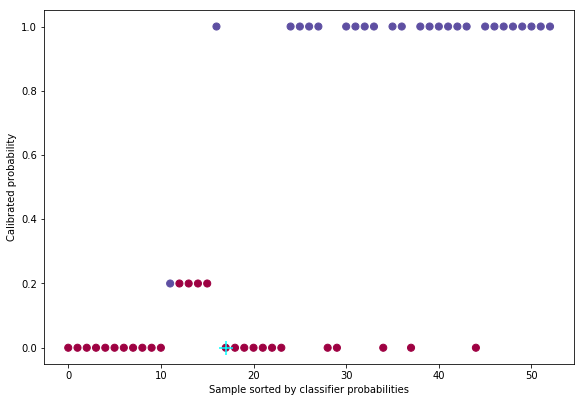

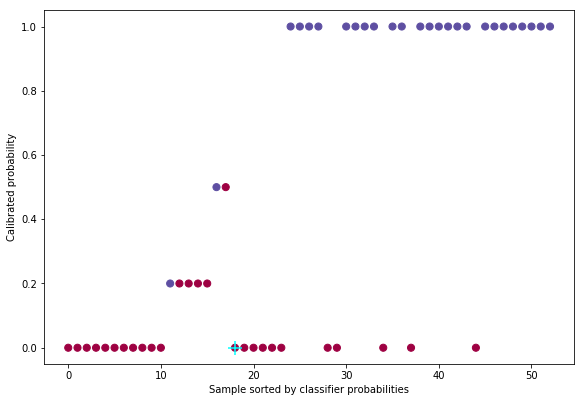

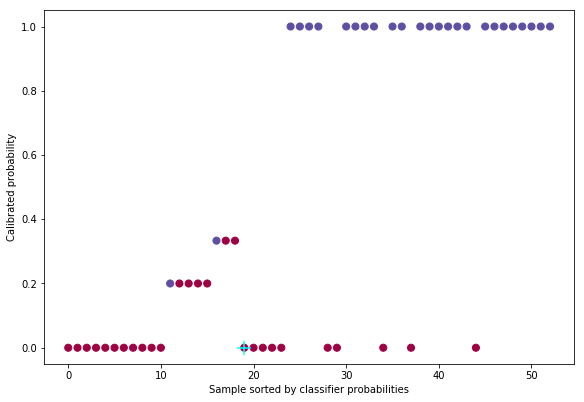

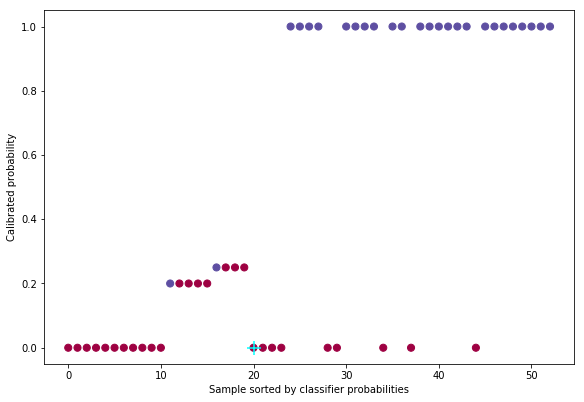

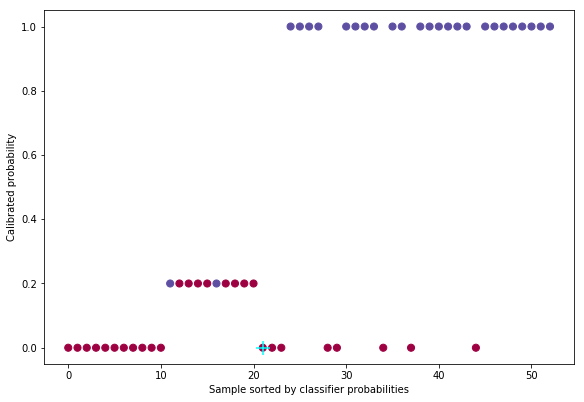

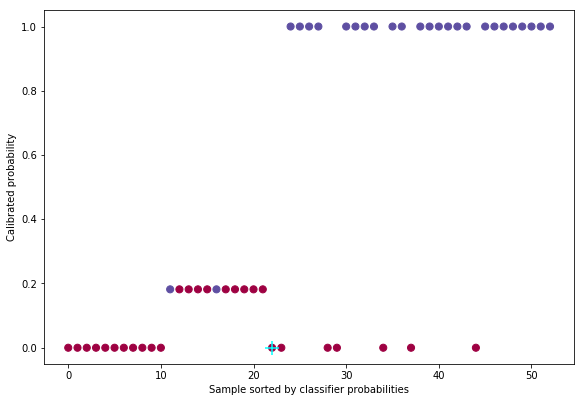

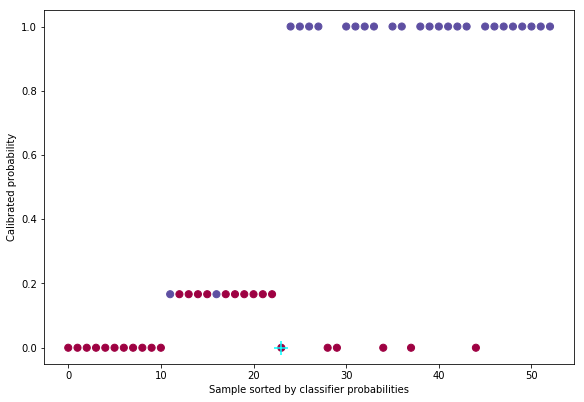

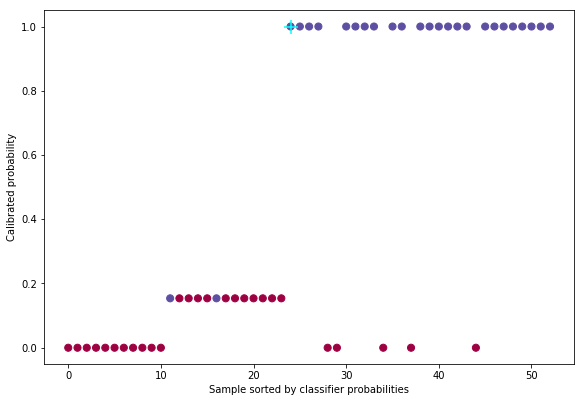

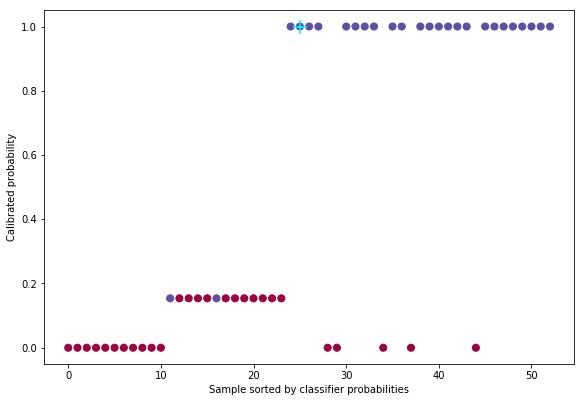

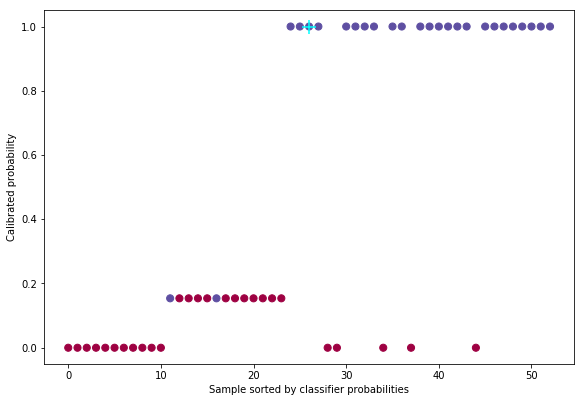

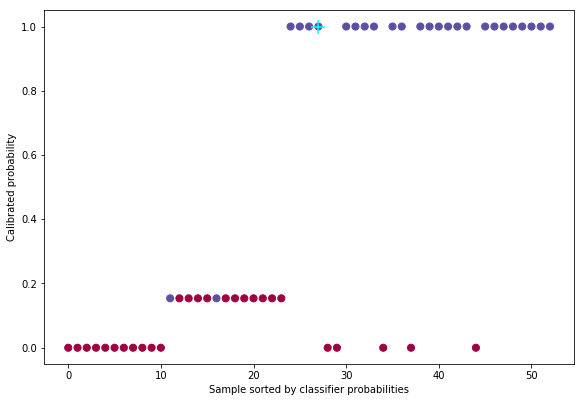

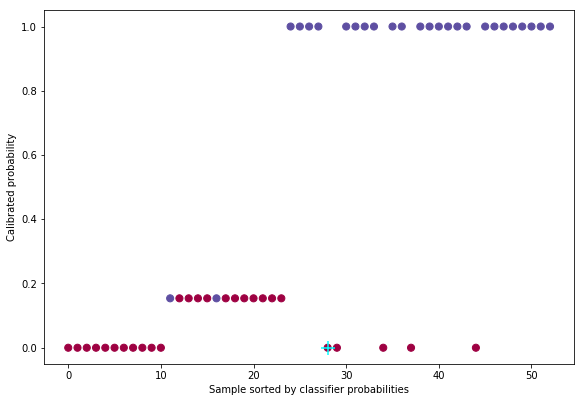

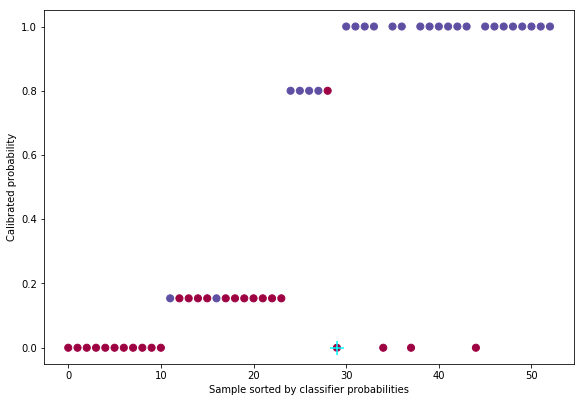

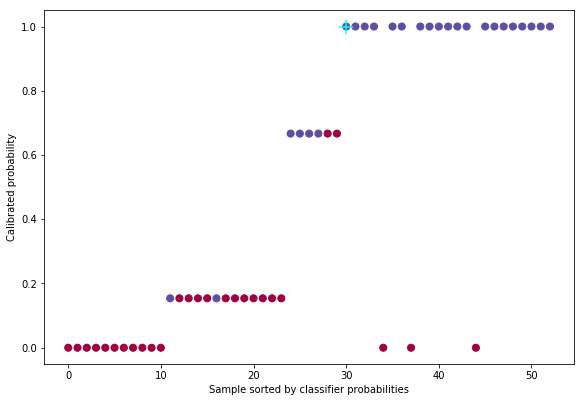

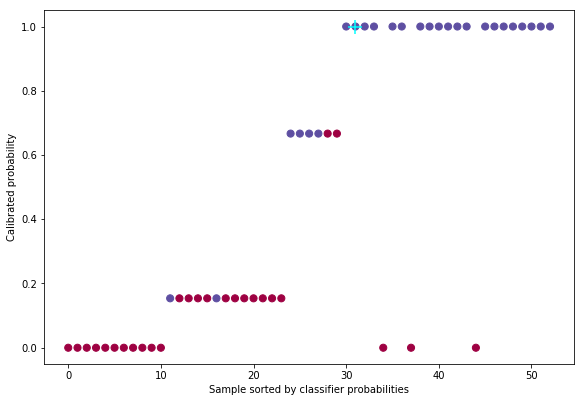

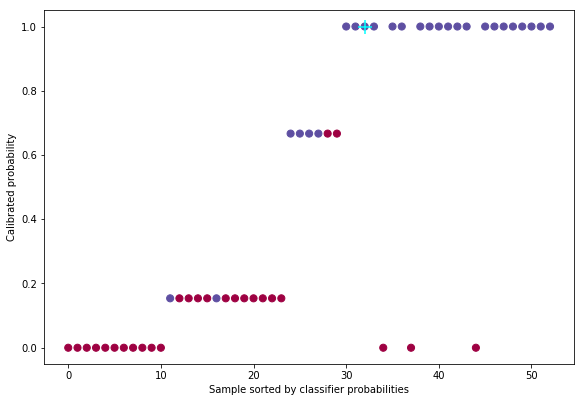

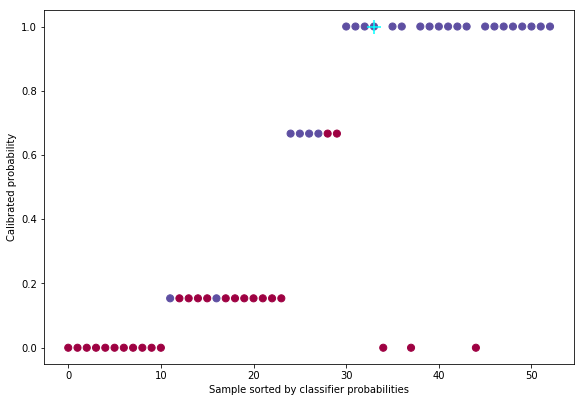

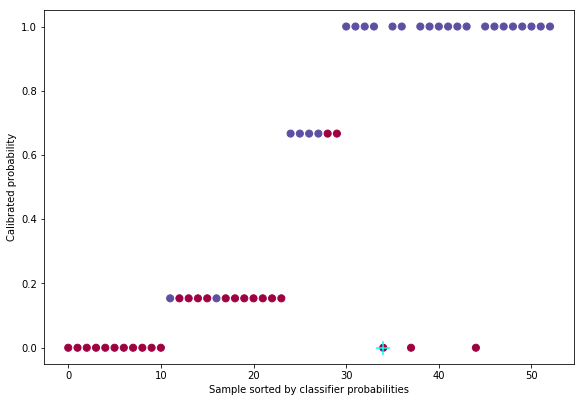

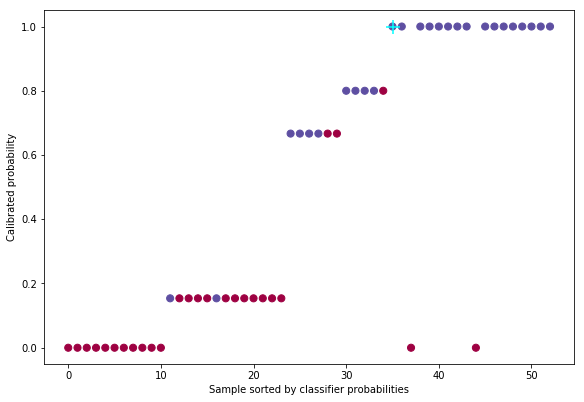

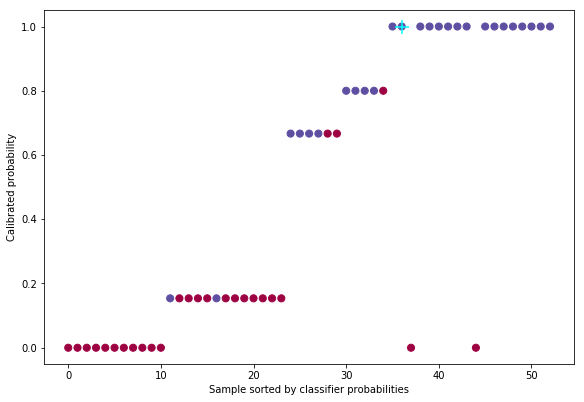

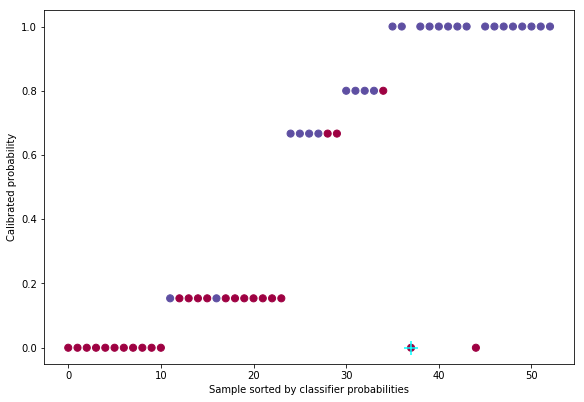

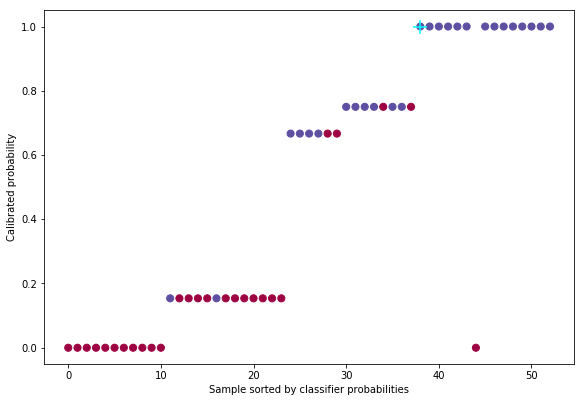

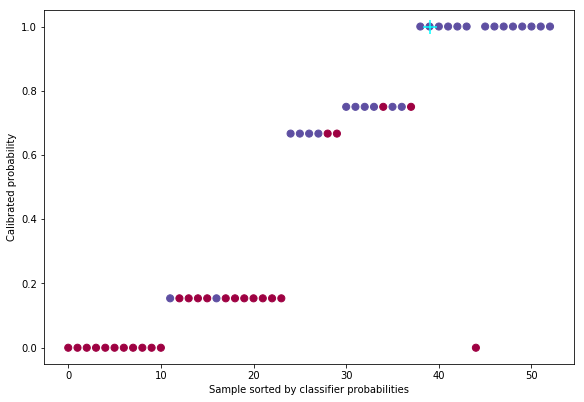

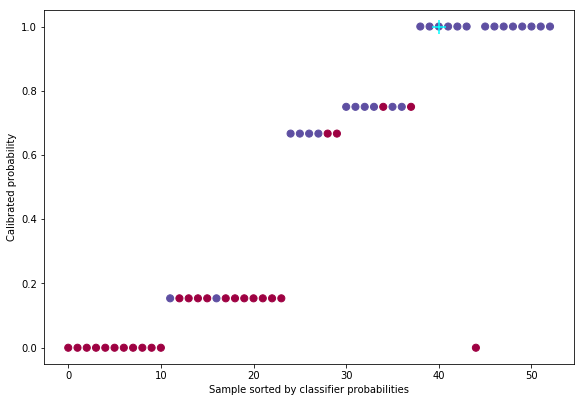

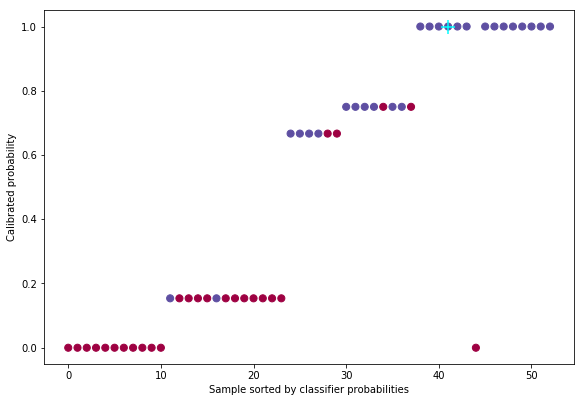

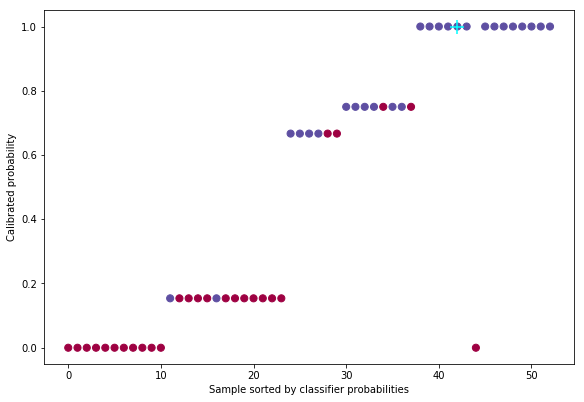

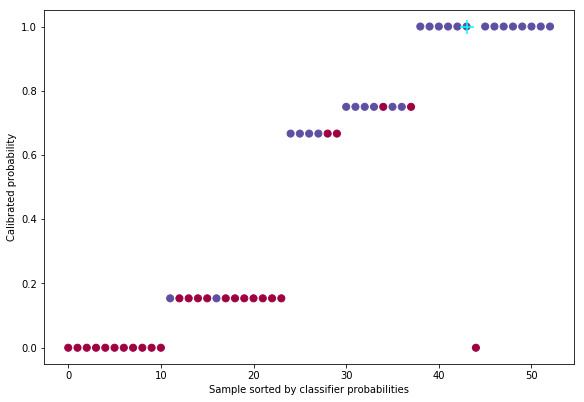

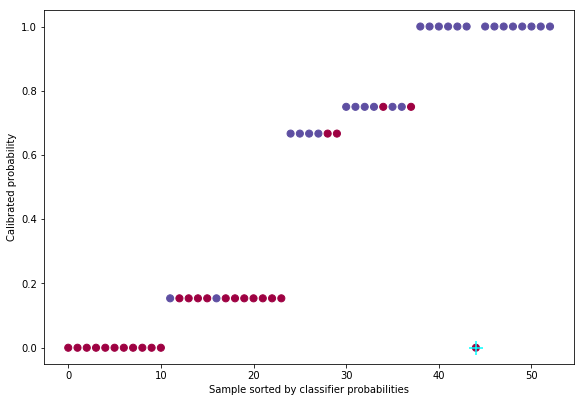

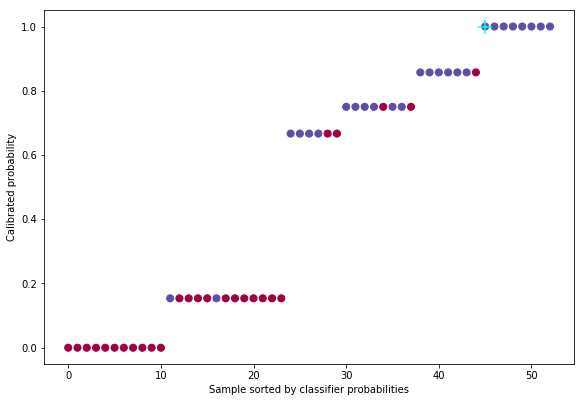

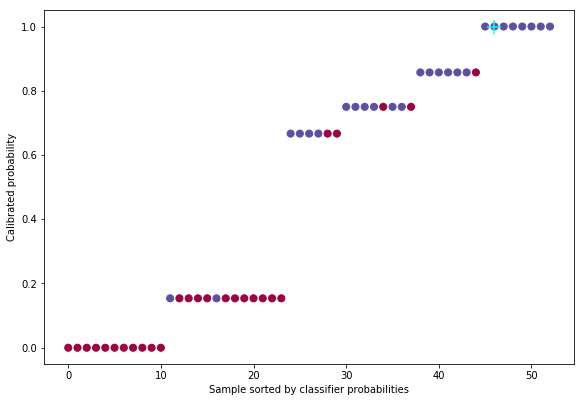

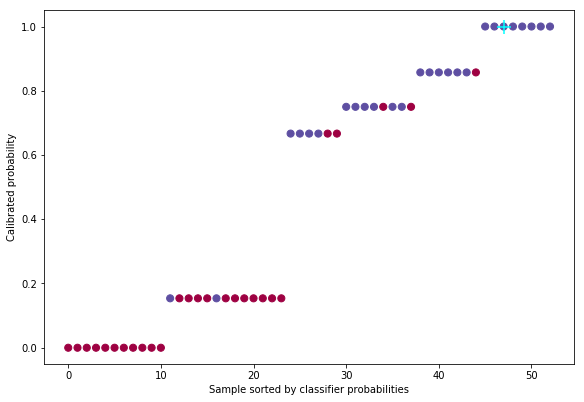

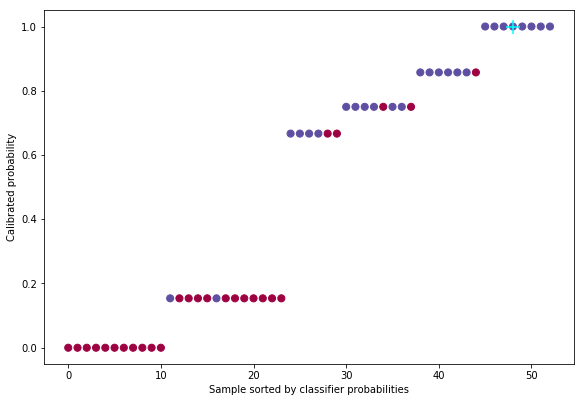

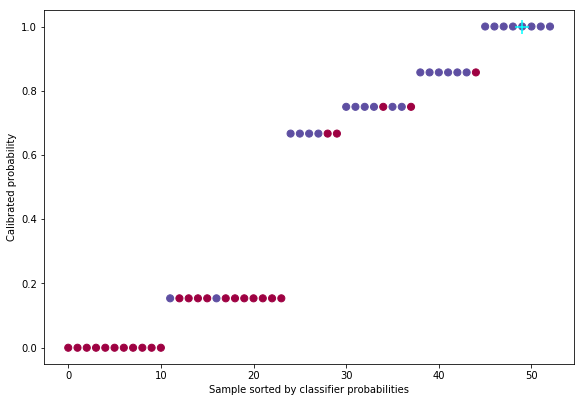

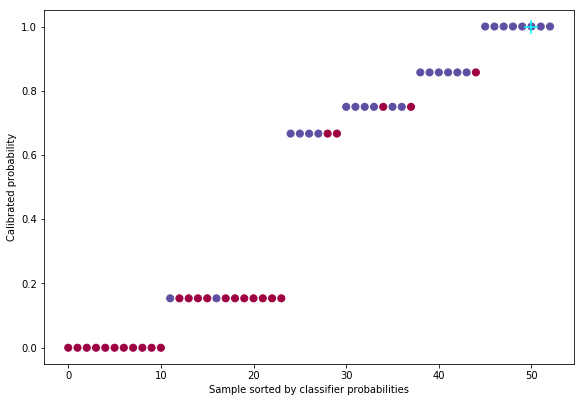

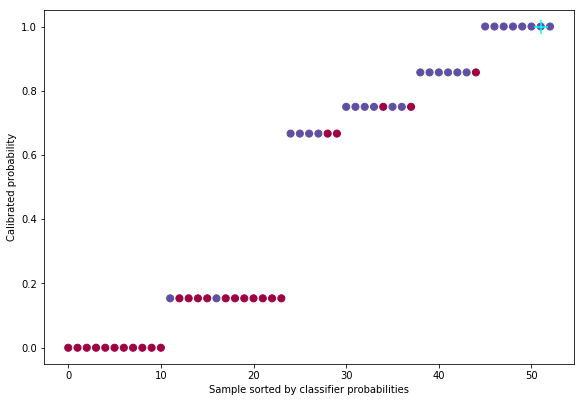

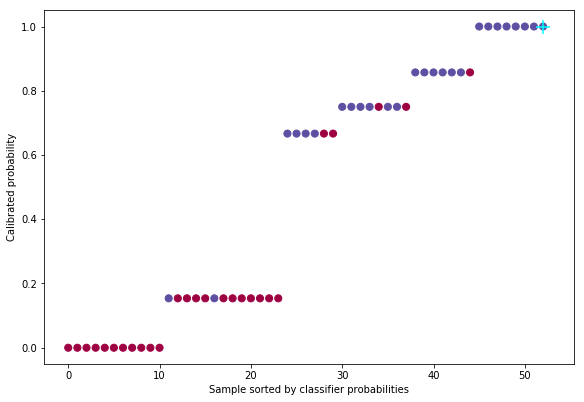

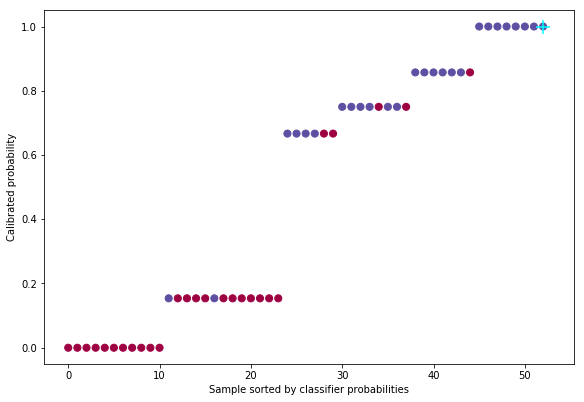

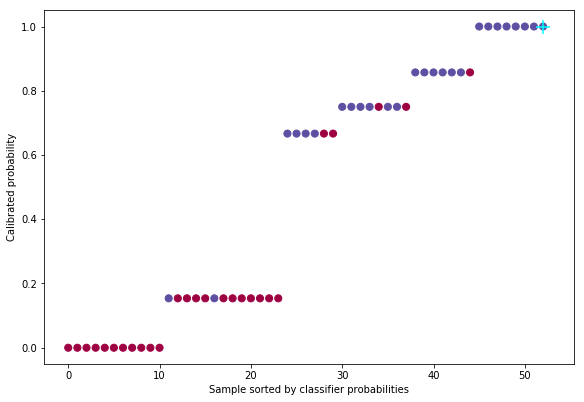

In [3]:
def plot_callback(y, active_set, counter, current):
    solution = np.empty(len(y))
    for value, weight, idx in active_set:
        solution[idx] = value / weight
    fig = plt.gcf()
    fig.set_size_inches(9.5,6.5)
    color = y.copy()
    plt.scatter(np.arange(len(y)), solution, s=50, cmap=plt.cm.Spectral, c=color)
    plt.scatter([np.arange(len(y))[current]], [solution[current]], s=200, marker='+', color='cyan')
    plt.ylim((-.05, 1.05))
    plt.ylabel('Calibrated probability')
    plt.xlabel('Sample sorted by classifier probabilities')
    plt.savefig('gif/isotonic_%03d.png' % counter)
    plt.show()


index_sorted_by_clf_proba = np.argsort(clf_proba)
sorted_y_cv = np.array([y_cv[i] for i in index_sorted_by_clf_proba])

selection_indices = [i for i in range(0, y_cv.shape[0], 400)]
selected_sorted_y_cv = np.take(sorted_y_cv, selection_indices)

calibrated_prob = isotonic_regression(selected_sorted_y_cv, callback=plot_callback)